<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span>
<li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Медленный-тренд" data-toc-modified-id="Медленный-тренд-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Медленный тренд</a></span></li><li><span><a href="#Случайные-события" data-toc-modified-id="Случайные-события-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайные события</a></span></li><li><span><a href="#Формирование-признаков" data-toc-modified-id="Формирование-признаков-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Формирование признаков</a></span></li><li><span><a href="#Кодирование-признаков" data-toc-modified-id="Кодирование-признаков-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Кодирование признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Иструмент-для-оптимизации-параметров-моделей" data-toc-modified-id="Иструмент-для-оптимизации-параметров-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Иструмент для оптимизации параметров моделей</a></span></li><li><span><a href="#Градиентный-бустинг-LightGBM" data-toc-modified-id="Градиентный-бустинг-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Градиентный бустинг LightGBM</a></span></li><li><span><a href="#Итоги-по-моделям-и-их-обучению" data-toc-modified-id="Итоги-по-моделям-и-их-обучению-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Итоги по моделям и их обучению</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Результаты-и-выводы" data-toc-modified-id="Результаты-и-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты и выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import tqdm

from ydata_profiling import ProfileReport

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
random_state = 12345

In [4]:
#data = pd.read_csv('taxi.csv')
data = pd.read_csv('/datasets/taxi.csv')

Первичный просмотр данных:

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Выводы по первичному просмотру:
* Всего две колонки - время и значение
* Все значения на месте
* Шаги по времени в десять минут с 2018-03-01 00:00:00 по 2018-08-31 23:50:00
* Повторов нет

Итак, с данными полный порядок. Нужно привести к типу datetime:

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'])

Отсортировать и проверить, какие бывают интервалы между строками:

In [7]:
data = data.sort_values(by='datetime')
data['datetime'].diff()[1:].value_counts()

0 days 00:10:00    26495
Name: datetime, dtype: int64

Все интервалы по 10 минут, пропусков нет. Индексируем:

In [8]:
data = data.set_index(data['datetime'], drop=True).sort_index()

## Анализ

### Сезонность

Для эффективного предсказания нужно сформировать хороший набор признаков, максимально отражающий закономерности в поведении целевого признака. Например, для такси обязательно ожидаем суточную и недельную периодичность. Посмотрим внимательнее с помощью seasonal_decompose. Но не будем жульничать и сначала выделим тестовую выборку:

In [9]:
train_valid, test = train_test_split(data, test_size=0.1, shuffle=False)

А вот в валидационную имеем право смотреть:

<AxesSubplot:xlabel='datetime'>

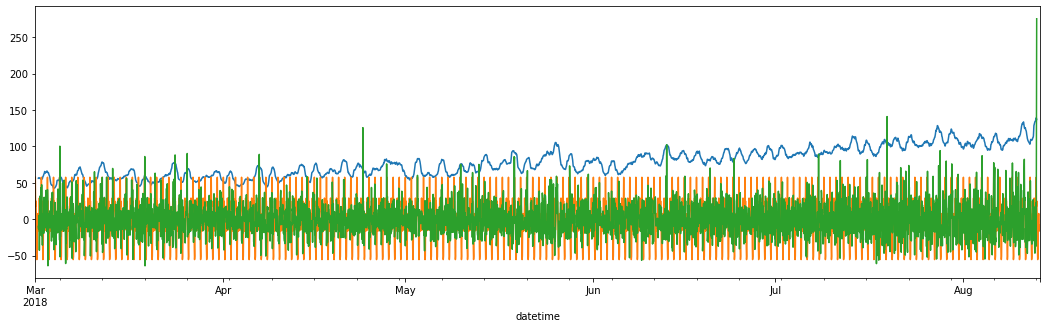

In [10]:
decomposed = seasonal_decompose(train_valid.resample('h').sum())
decomposed.trend.plot(figsize=(18,5)) 
decomposed.seasonal.plot(figsize=(18,5)) 
decomposed.resid.plot(figsize=(18,5)) 

Суточная периодичность налицо. Попробуем выделить недельную. Для этого усредним по суткам и посмотрим еще раз:

<AxesSubplot:xlabel='datetime'>

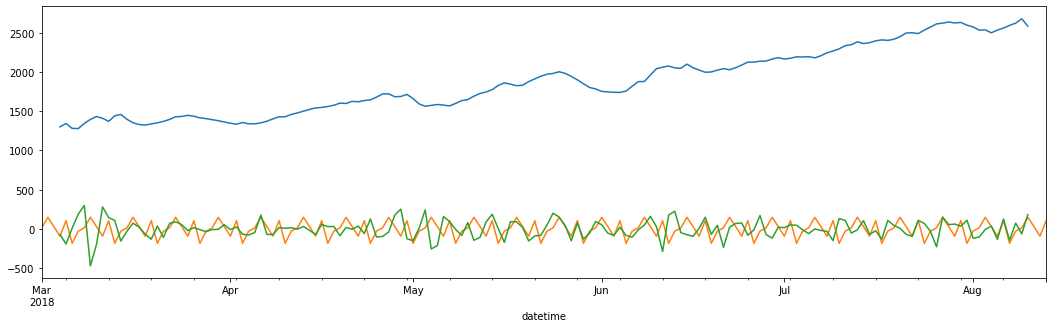

In [11]:
decomposed = seasonal_decompose(train_valid.resample('D').sum())
decomposed.trend.plot(figsize=(18,5))
decomposed.seasonal.plot(figsize=(18,5))
decomposed.resid.plot(figsize=(18,5)) 

<AxesSubplot:xlabel='datetime'>

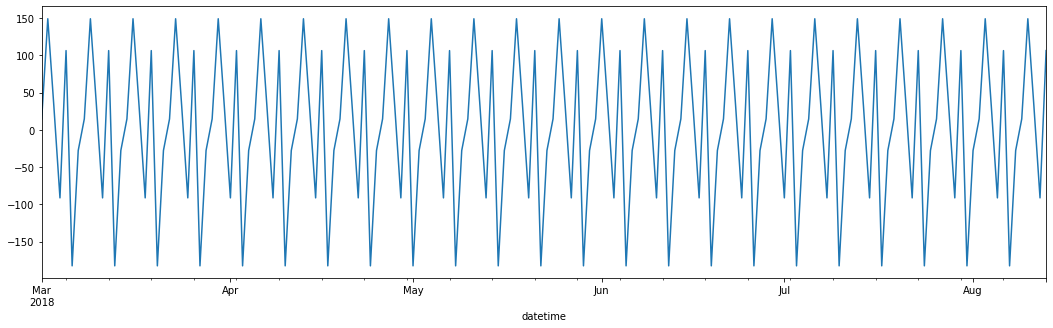

In [12]:
decomposed.seasonal.plot(figsize=(18,5))

Недельная периодичность тоже ясно выражена. Время суток и день недели должны быть ключевыми признаками.

### Медленный тренд

Из декомпозиции виден тренд на постепенное увеличение числа заказов. Чтобы увидеть его яснее, посмотрим на среднее за четыре недели:

<AxesSubplot:xlabel='datetime'>

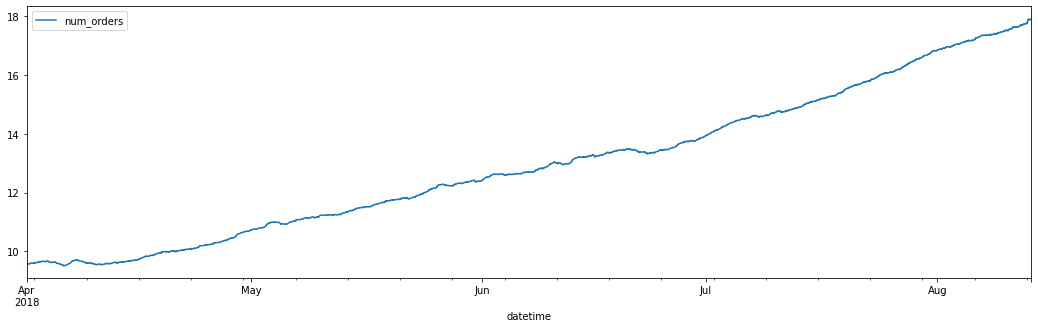

In [13]:
train_valid.rolling('28D').mean()['2018-04':].plot(figsize=(18,5))

И включим в признаки такое среднее.

Отметим, что среднее за четыре недели выглядит похоже на линейный тренд. После первого месяца популярность сервиса такси  растет почти линейно. Можно попробовать аппроксимировать эту динамику линейной моделью:

<AxesSubplot:xlabel='datetime'>

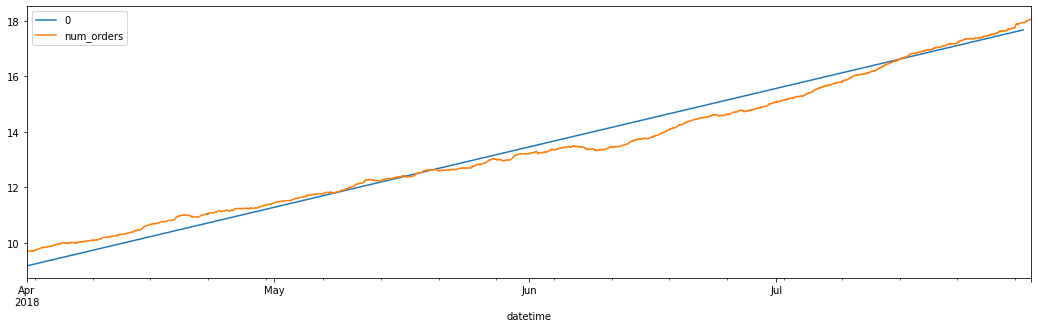

In [14]:
trend_model = LinearRegression()
trend_model.fit(train_valid.resample('D').mean()['2018-04':].index.dayofyear[:,None],
                train_valid.resample('D').mean()['2018-04':])
ax = plt.gca()
pd.DataFrame(trend_model.predict(train_valid.resample('D').mean()['2018-04':].index.dayofyear[:,None]),
            index = train_valid.resample('D').mean()['2018-04':].index)['2018-04':'2018-07'].plot(ax=ax, figsize=(18,5))

train_valid.rolling('28D', center=True).mean()['2018-04':'2018-07'].plot(ax=ax)

В отличие от усреднения за последний месяц, обученная на тренировочной выборке линейная модель позволяет избежать "задержки" в половину периода усреднения. В то же время, она может начать сильно ошибаться при экстраполяции за пределы тренировочного интервала, если там тренд изменится, а бегущее среднее позволило бы учеть такие изменения. Оставим пока оба варианта.

### Случайные события

Помимо устойчивых тенденций и случайностей, спрос на такси может зависеть от текущих событий, которые уже нашли отражение в данных ряда за предыдущие интервалы времени. Соответственно, предказание на будущий спрос можно попробовать скорректировать с учетом последней динамики или ее расхождений со средними показателями. Попробуем учесть такие возможные зависимости с помощью ряда дополнительных признаков, чтобы потом найти наиболее удачные варианты. Поскольку временной ряд имеет сильно выраженную периодичность в неделю, предположим, что количество заказов в моменты времени с одинаковым смещением от начала недели должно в среднием отличаться меньше, чем заказы в случайные моменты времени. Вычислим для каждого момента времени среднее количество заказов за предыдущие недели. Рассмотрим в качестве признаков следующие варианты:
* Среднее количество заказов на предыдущем интервале времени
* Разность количества заказов в два предыдущих момента времени (грубая оценка производной как признак роста)
* Среднее отличие количества заказов на предыдущем интервале времени от средних значений за те же интервалы времени в предыдущие несколько недель

Кроме того, попробуем учесть линейный нарастающий тренд и посчитать альтернативное среднее для смещений от начала недели, нормируя количество заказов на значение из тренда. Фактически, это будет вычисленное по предыдущим неделям ожидаемое среднее. Значение возьмем из уже обученной модели линейной регресии. Вычислим альтернативную версию последнего признака по ожидаемому среднему.

In [15]:
# Функция вычисляет время от начала недели, которая начинается с base_day
def make_offset(row, base_day):
    return 24*60*((row['datetime'].day+7-base_day)%7) + 60*row['datetime'].hour + row['datetime'].minute

# функция создает копию df с колонками average и average_fixed
# для каждого момента времени вычисляется среднее количество заказов в такие моменты времени в предыдущих неделях
# в колонке average_fixed данные дополнительно нормируются на линейный тренд в надежде,
# что такие средние точнее приблизят значения в будущем
def make_previos_weeks_average(df, num_of_weeks):
    tmpdf = df.copy()
    # offset - время в минутах от начала недельного периода. периоды начинаются с первого дня в датасете
    tmpdf['offset']  = tmpdf.apply(make_offset, axis=1, args=[tmpdf.index[0].day])
    tmpdf['average'] = float(0)
    tmpdf['average_fixed'] = float(0)
    tmpdf['trend_fix'] = trend_model.predict(tmpdf.index.dayofyear[:,None]) # значения линейного тренда для каждого дня
    tmpdf['trend_fixed'] = tmpdf['num_orders'] / tmpdf['trend_fix'] # все данные будут входить в среднее с весом из тренда

    date = tmpdf.index[0]
    while date < tmpdf.index[-1]: # цикл по всем неделям из df
        date += pd.DateOffset(days=7)
        
        # заполняем недельную часть колонки average средними по всем предыдущим неделям, сгруппированными по offset
        tmpdf.loc[date:date+pd.DateOffset(days=7, minutes=-1), 'average'] = \
            tmpdf[date-pd.DateOffset(days=7*num_of_weeks) : date+pd.DateOffset(minutes=-1)] \
             .groupby('offset')['num_orders'].mean().values \
            [:len(tmpdf.loc[date:date+pd.DateOffset(days=7, minutes=-1), 'average'])] # чтобы не вылезти за датасет
        
        # заполняем колонку average_fixed аналогично, но нормированными на тренд данными из trend_fixed
        tmpdf.loc[date:date+pd.DateOffset(days=7, minutes=-1), 'average_fixed'] = \
            tmpdf[date-pd.DateOffset(days=7*num_of_weeks):date+pd.DateOffset(minutes=-1)] \
             .groupby('offset')['trend_fixed'].mean().values \
            [:len(tmpdf.loc[date:date+pd.DateOffset(days=7, minutes=-1), 'average_fixed'])] # чтобы не вылезти за датасет   
        
    # обратно корректируем на тренд, теперь в average будет среднее за предыдущие недели,
    # а в average_fixed будет "ожидаемое согласно тренду среднее за предыдущие недели"
    tmpdf['average_fixed'] = tmpdf['average_fixed'] *  tmpdf['trend_fix'] 
    tmpdf = tmpdf.drop(['trend_fixed', 'trend_fix', 'offset'], axis=1) # выбросим временные колонки
    return tmpdf



Отметим, что вычисленные ожидаемые значения фактически являются предсказаниями и посмотрим, насколько они совпадают с реальными:

In [16]:
tmpdf = make_previos_weeks_average(train_valid, 10)
tmpdf = tmpdf.resample('h').sum()
print('RMSE ожидаемых средних без учета линейного тренда', 
      mean_squared_error(tmpdf['num_orders'], tmpdf['average'], squared=False))
print('RMSE ожидаемых средних с учетом линейного тренда', 
      mean_squared_error(tmpdf['num_orders'], tmpdf['average_fixed'], squared=False))

RMSE ожидаемых средних без учета линейного тренда 30.048357587897627
RMSE ожидаемых средних с учетом линейного тренда 28.833100656028567


Интересно, что достигнутая точность предсказаний является достаточной по условиям задания. Первые модели готовы, можно строить признаки)

### Формирование признаков

Часть признаков планировалось строить на основе исходных данных, а часть лучше строить после ресемплинга в часовые интервалы. Поэтому совместим построение признаков и ресемплинг:

In [17]:
def make_features_resample(df, num_weeks, num_slices):  # num_slices не больше 6, это количество усредняемых значений
    df_new = make_previos_weeks_average(df, num_weeks)  # получим ожидаемые средние
    # предыдущее значение. where чтобы занулить остальные из этого часа для ресемплинга с суммированием
    df_new['last_value'] = df_new['num_orders'].where(df_new.index.minute==50, 0).shift(1)
    # разность предыдущтх значений. грубый аналог производной, как показателя роста заказов 
    df_new['last_value_delta'] = df_new['num_orders'].where(df_new.index.minute==50, 0).shift(1) - df_new['num_orders'].where(df_new.index.minute==40, 0).shift(2)
    df_new['last_value_minus_avg'] = (df_new['num_orders']-df_new['average']).where(df_new.index.minute>=60-10*num_slices, 0).shift(6)
    df_new['last_value_minus_avg_fixed'] = (df_new['num_orders']-df_new['average_fixed']).where(df_new.index.minute>=60-10*num_slices, 0).shift(6)
    
    df_new = df_new.resample('h').sum()    # ресемплинг в часы

    df_new['trend'] = df_new['num_orders'].rolling('28D').mean().shift(1)   # нарастающий тренд в качестве признака
    df_new['trend_linear'] = 6*trend_model.predict(df_new.index.dayofyear[:,None]) # и его линейная аппроксимация
    df_new['weekday'] = df_new.index.weekday # день недели 
    df_new['hour'] = df_new.index.hour       # и час
    return df_new

In [18]:
features_train_valid = make_features_resample(train_valid, 10, 3)
features_train_valid = features_train_valid['2018-04-01':] # отбросим первый месяц, где неправильно считается признак trend

In [20]:
features_train_valid

,num_orders,average,average_fixed,last_value,last_value_delta,last_value_minus_avg,last_value_minus_avg_fixed,trend,trend_linear,weekday,hour
datetime,,,,,,,,,,,
2018-04-01 00:00:00,85,72.000000,84.012145,7.0,4.0,-21.250000,-26.785877,57.452381,54.993322,6,0
2018-04-01 01:00:00,42,82.000000,93.945305,20.0,-2.0,19.500000,13.093578,57.467262,54.993322,6,1
2018-04-01 02:00:00,34,35.250000,40.453222,11.0,6.0,-12.250000,-17.961964,57.440476,54.993322,6,2
2018-04-01 03:00:00,24,43.750000,50.727977,3.0,-1.0,-11.750000,-15.181032,57.452381,54.993322,6,3
2018-04-01 04:00:00,39,28.000000,32.388208,10.0,6.0,0.250000,-2.609050,57.425595,54.993322,6,4
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 10:00:00,156,112.666667,131.238270,16.0,-3.0,18.333333,11.152840,107.330357,111.559664,0,10
2018-08-13 11:00:00,144,75.888889,88.970114,31.0,-3.0,30.666667,20.989098,107.395833,111.559664,0,11
2018-08-13 12:00:00,92,83.666667,97.131309,21.0,-8.0,26.555556,19.352818,107.428571,111.559664,0,12


### Кодирование признаков

День недели - заведомо категориальный признак. Спрос на такси по субботам никак не связан со спросом в пятницы. Номер часа тоже может оказаться выгоднее считать категориальным с точки зрения спроса на такси. Попробуем OHE и обучим соответствующие кодировщики:

In [21]:
ohe_categories_1 = ['weekday']
ohe_categories_2 = ['weekday', 'hour']
ohe_1 = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
ohe_2 = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
ohe_1.fit(features_train_valid[ohe_categories_1])
ohe_2.fit(features_train_valid[ohe_categories_2])

# функция кодирует признаки categories из df кодером ohe
def ohe_df(df, ohe, categories):
    temp_df = pd.concat([df.reset_index(drop=True), pd.DataFrame(ohe.transform(df[categories]),
                                                                 columns=ohe.get_feature_names_out())], axis=1)
    return temp_df.drop(categories, axis=1)

## Обучение

### Линейная регрессия

Подготовим функции для отбора признаков

In [22]:
def make_feature_list(features):
    feature_list = ['num_orders', 'average', 'average_fixed', 'last_value', 'last_value_delta', 
                     'last_value_minus_avg', 'last_value_minus_avg_fixed', 'trend', 'trend_linear', 'weekday', 'hour']
    for feature in features:
        feature_list.remove(feature)
    return feature_list

def drop_features(df, feature_list):
    return df.drop(make_feature_list(feature_list), axis=1)

In [23]:
def make_features_targets(df, feature_list):
    features_train, features_valid = train_test_split(df, test_size=0.1, shuffle=False)
    features_train = features_train.dropna()
    target_train, target_valid = features_train['num_orders'], features_valid['num_orders']
    features_train = drop_features(features_train, feature_list)
    features_valid = drop_features(features_valid, feature_list)
    return features_train, features_valid, target_train, target_valid

И попробуем модель с самыми очевидными признаками:

In [24]:
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, feature_list)
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
mean_squared_error(target_valid, lr_model.predict(features_valid), squared=False)

47.054344265261705

Получилось плохо. Наша случайно созданная в анализе модель фактически была набором DummyRegressor'ов, каждый для своего значения времени в неделе, и справилась значительно лучше. Попробуем OHE, пусть линейная модель тоже рассматривает каждый час отдельно:

In [25]:
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
print('RMSE при OHE weekday:', mean_squared_error(target_valid, lr_model.predict(features_valid), squared=False))
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, feature_list)
features_train = ohe_df(features_train, ohe_2, ohe_categories_2)
features_valid = ohe_df(features_valid, ohe_2, ohe_categories_2)
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
print('RMSE при OHE weekday+hour:', mean_squared_error(target_valid, lr_model.predict(features_valid), squared=False))

RMSE при OHE weekday: 46.5604169143185
RMSE при OHE weekday+hour: 33.019850629773046


Точность приблизилась к результатам первых моделей, но остается хуже. Попробуем лес.

### Случайный лес

Без OHE:

In [26]:
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid['2018-04-01':], feature_list)

In [27]:
%%time
rf_model = RandomForestRegressor(max_depth=20, n_estimators=100, random_state=random_state)
rf_model.fit(features_train, target_train)
mean_squared_error(target_valid, rf_model.predict(features_valid), squared=False)

CPU times: total: 781 ms
Wall time: 443 ms


31.255926860179475

И с разными вариантами OHE:

In [28]:
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid['2018-04-01':], feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)

In [29]:
%%time
rf_model = RandomForestRegressor(max_depth=20, n_estimators=100, random_state=random_state)
rf_model.fit(features_train, target_train)
mean_squared_error(target_valid, rf_model.predict(features_valid), squared=False)

CPU times: total: 500 ms
Wall time: 514 ms


31.54289445479631

In [30]:
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid['2018-04-01':], feature_list)
features_train = ohe_df(features_train, ohe_2, ohe_categories_2)
features_valid = ohe_df(features_valid, ohe_2, ohe_categories_2)

In [31]:
%%time
rf_model = RandomForestRegressor(max_depth=20, n_estimators=100, random_state=random_state)
rf_model.fit(features_train, target_train)
mean_squared_error(target_valid, rf_model.predict(features_valid), squared=False)

CPU times: total: 703 ms
Wall time: 723 ms


35.57187044791704

Линейную регрессию обогнали. Еще для случайного леса оказался не очень нужен OHE для дней недели, а OHE для часов заметно портит результат.

### Иструмент для оптимизации параметров моделей

Модели градиентного бустинга имеют параметры с выраженными оптимальными значениями. Построим алгоритм подбора таких параметров в рамках однопараметрической оптимизации. Стандартный метод оптимизации - градиентный спуск - здесь применять затруднительно, поскольку метрика принципиально недифференцируема по гиперпараметрам моделей вследствие наличия в моделях случайного фактора. Будем использовать последовательную аппроксимацию параболой по трем точкам:
* найдем в списке три точки, где метрики в средней по параметру точке меньше, чем в крайних
* найдем параболу, которая через эти точки проходит
* найдем значение параметра, соответствующее минимуму параболы
* вычислим функцию в этом минимуме, добавим эту точку в список
* повторяем процедуру, пока точки не будут достаточно близко

In [32]:
# класс предлагается инициализировать, затем брать значения параметра из current_value 
# и регистрировать значения метрики методом add_metric_value, пока add_metric_value не вернет True

# параметры инициализации: 
# initial_values - начальный вектор значений параметра, может быть любой длины
# stop_relation - целевое отношение соседних значений параметра для остановки поиска
# step_method - способ формирования трех точек для первой параболы дугой вниз
# step_method = 'geometric' - делим или умножаем значение с минимальной метрикой на geometric_step
# step_method = 'dichotomy' - делим интервал с минимальной метрикой на границах пополам
# step_method = 'geometric_dichotomy' - делим интервал с минимальной метрикой на границах средним геометрическим

class one_parameter_parabolic_optimizer:
    def __init__(self, initial_values, stop_relation=1.1, step_method='nothing', geometric_step=2):      
        self.data = pd.DataFrame(columns=('parameter','metric','x2','x','1'), dtype='float')
        self.parabolic_mode = False
        self.parabolic_error = False
        self.stop_relation_log = np.log(stop_relation)
        self.initial_values = initial_values            
        self.step_method = step_method                              
        self.geometric_step = geometric_step
        self.initial_counter = 0
        self.current_value = self.initial_values[0]
        
    def best_value(self):
        return self.data.loc[self.data['metric'].idxmin(), 'parameter']
    
# строим параболу через точку с минимальной метрикой и две соседние и ищем ее минимум
    def next_parabolic(self):                      
        self.data['x2'] = self.data['parameter']**2
        self.data['x'] = self.data['parameter']
        self.data['1'] = 1
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()
        matrix = self.data[['x2','x','1']][index_min-1:index_min+2]
        y = self.data['metric'][index_min-1:index_min+2]
        vector_abc = np.linalg.inv(matrix) @ y
        return -vector_abc[1]/vector_abc[0]/2

    def next_geometric(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return self.data.loc[index_min, 'parameter']/self.geometric_step
        else:
            return self.data.loc[index_min, 'parameter']*self.geometric_step
        
    def next_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min+1, 'parameter'])/2
        else:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min-1, 'parameter'])/2
        
    def next_geometric_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min+1, 'parameter'])**0.5
        else:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min-1, 'parameter'])**0.5
    
    def add_metric_value(self, metric_value):
        if self.parabolic_error:           # записана ошибка, выход
                return True
        self.data.loc[self.data.shape[0]] = [self.current_value, metric_value, 0, 0, 0]   # новое значение в таблицу
        if self.initial_counter+1 < len(self.initial_values) :              # если начальные значения не закончились,
            self.initial_counter+=1                                         # то считаем метрику в них
            self.current_value = self.initial_values[self.initial_counter]
            return False
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()         # ищем минимальную метрику
        parabolic_ready = (index_min!=0) and (index_min!=self.data.shape[0]-1)      # и выясняем, на краю ли она таблицы
        if parabolic_ready:
            self.parabolic_mode = True                               # если не на краю, дальше считаем параболой                  
            self.current_value = self.next_parabolic()
            loglog = abs(np.array([np.log(self.data.loc[index_min-1,'parameter'])-np.log(self.data.loc[index_min,'parameter']),
                              np.log(self.data.loc[index_min+1,'parameter']) -np.log(self.data.loc[index_min,'parameter'])]))            
            return loglog.min() < self.stop_relation_log   # пока не выполним критерий
        elif self.parabolic_mode:    # если уже была парабола, а теперь не получается, то пишем ошибку: метод расходится
            return True
        elif self.step_method == 'geometric': # если еще нет точек для параболы и задана геометрическая прогрессия
            self.current_value = self.next_geometric()
            return False
        elif self.step_method == 'dichotomy': # если еще нет точек для параболы и задана дихотомия 
            self.current_value = self.next_dichotomy()
            return False
        elif self.step_method == 'geometric_dichotomy': # если еще нет точек для параболы и задана geometric_dichotomy 
            self.current_value = self.next_geometric_dichotomy()
            return False
        else: # если еще нет точек для параболы и метод поиска не задан, завершаем
            return True

### Градиентный бустинг LightGBM

Поскольку LightGBM строит модель из деревьев, применим вариант OHE, который был лучше для случайного леса:

In [33]:
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid['2018-04-01':], feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)

Подберем learning_rate:

In [34]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.01], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    lgbm_model = LGBMRegressor(num_leaves=200, learning_rate=learning_rate, num_iterations=300, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'learning rate = {learning_rate:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_learning_rate = optimizer.best_value()

learning rate = 0.01000 rmse = 31.6
learning rate = 0.00500 rmse = 34.9
learning rate = 0.02000 rmse = 30.8
learning rate = 0.04000 rmse = 29.8
learning rate = 0.08000 rmse = 29.7
learning rate = 0.16000 rmse = 29.1
learning rate = 0.32000 rmse = 29.5
learning rate = 0.20972 rmse = 29.3
learning rate = 0.15971 rmse = 29.3
CPU times: total: 11.7 s
Wall time: 3.13 s


In [35]:
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid['2018-04-01':], feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)

In [36]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.2, 1], 1.03, step_method='geometric_dichotomy')
start_index = features_train.index[0]
end_index = features_train.index[-1]
for i in range(10):
    current_start_index = start_index + int(optimizer.current_value*(start_index-end_index))
    lgbm_model = LGBMRegressor(num_leaves=200, learning_rate=best_learning_rate, num_iterations=300, random_state=random_state)
    lgbm_model.fit(features_train[current_start_index:], target_train[current_start_index:])
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'train part = {optimizer.current_value:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
#best_learning_rate = optimizer.best_value()

train part = 0.20000 rmse = 30.8
train part = 1.00000 rmse = 29.6
train part = 0.44721 rmse = 30.1
train part = 0.66874 rmse = 30.3
train part = 0.81777 rmse = 29.9
train part = 0.90430 rmse = 29.5
train part = 0.93150 rmse = 30.3
train part = 0.86853 rmse = 30.3
train part = 0.90037 rmse = 29.6
CPU times: total: 9.36 s
Wall time: 2.43 s


С бустингом получилось чуть лучше, чем со случайным деревом, но все еще чуть хуже, чем предсказание средними значениями из первых моделей. Посмотрим, что будет если бегущее среднее заменить линейной аппроксимацией тренда:

In [37]:
feature_list = ['weekday', 'hour', 'trend_linear']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)
lgbm_model = LGBMRegressor(num_leaves=200, learning_rate=best_learning_rate, num_iterations=300, random_state=random_state)
lgbm_model.fit(features_train, target_train)
mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)

29.868655153145156

Нет, линейная аппроксимация тренда не улучшает результат.

Отметим, что мы все еще не использовали ни один из признаков, описывающих динамику, непосредственно предшествующую предсказываемому часу. Посмотрим, что дадут эти признаки, если их добавлять по одному:

In [38]:
basic_features = ['weekday', 'hour', 'trend']
feature_list = make_feature_list(basic_features + ['num_orders', 'trend_linear'])
lgbm_model = LGBMRegressor(num_leaves=200, learning_rate=best_learning_rate, num_iterations=300, random_state=random_state)
for feature in feature_list:
    features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, 
                                                                                       basic_features + [feature])
    features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
    features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'feature = {feature:>28}      rmse = {rmse:.1f}')

feature =                      average      rmse = 32.4
feature =                average_fixed      rmse = 32.9
feature =                   last_value      rmse = 31.5
feature =             last_value_delta      rmse = 30.7
feature =         last_value_minus_avg      rmse = 32.5
feature =   last_value_minus_avg_fixed      rmse = 33.5


Ни один из предложенных признаков, описывающих последнюю динамику, не дал улучшения предсказаний. Выходит так, что улучшить предсказания за учетом последней динамики не получилось. Отметим также, что признаки average и average_fixed фактически кодируют weekday и hour методом target encoding и пользы от них тоже не получается. Попробуем еще небольшую оптимизацию по num_leaves:

In [39]:
%%time
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)

optimizer = one_parameter_parabolic_optimizer([20, 500], 1.03, step_method='geometric_dichotomy')
for i in range(10):
    num_leaves = int(optimizer.current_value)
    lgbm_model = LGBMRegressor(num_leaves=num_leaves, learning_rate=best_learning_rate,  
                               num_iterations=1000, 
                               random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'num_leaves = {num_leaves:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_num_leaves = int(optimizer.best_value())

num_leaves = 20.00000 rmse = 29.2
num_leaves = 500.00000 rmse = 29.9
num_leaves = 100.00000 rmse = 29.7
num_leaves = 44.00000 rmse = 29.0
num_leaves = 44.00000 rmse = 29.0
CPU times: total: 13.5 s
Wall time: 3.63 s


И небольшую оптимизацию по feature_fraction:

In [40]:
%%time
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)

optimizer = one_parameter_parabolic_optimizer([0.1, 0.7], 1.03, step_method='dichotomy')
for i in range(10):
    feature_fraction = optimizer.current_value
    lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate,  
                               num_iterations=1000, 
                               feature_fraction=feature_fraction, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'feature_fraction = {feature_fraction:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_feature_fraction = optimizer.best_value()

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
feature_fraction = 0.10000 rmse = 33.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
feature_fraction = 0.70000 rmse = 28.9
[LightGBM] [Warning] feature_fraction is set=0.39999999999999997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39999999999999997
feature_fraction = 0.40000 rmse = 28.6
[LightGBM] [Warning] feature_fraction is set=0.5317157819665138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5317157819665138
feature_fraction = 0.53172 rmse = 28.8
[LightGBM] [Warning] feature_fraction is set=0.4470162709774286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4470162709774286
feature_fraction = 0.44702 rmse = 28.8
[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, colsample_bytree=1.0 will be

Подбор num_leaves и feature_fraction дал некоторое улучшение. Еще попробуем учить модели только на части выборки. Модель воспринимает все значения из выборки как равнозначные. Гипотеза: последняя динамика может быть ближе к поведению в будущем, поэтому обучение на срезе вблизи конечной даты может оказаться лучше, чем учет всех значений.

In [41]:
%%time
feature_list = ['weekday', 'hour', 'trend']
features_train, features_valid, target_train, target_valid = make_features_targets(features_train_valid, feature_list)
features_train = ohe_df(features_train, ohe_1, ohe_categories_1)
features_valid = ohe_df(features_valid, ohe_1, ohe_categories_1)

start_index = features_train.index[0]
end_index = features_train.index[-1]
for i in range(1,11):
    current_start_index = end_index - int(i*(end_index-start_index)/10)
    lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate, num_iterations=1000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
    lgbm_model.fit(features_train[current_start_index:], target_train[current_start_index:])
    rmse = mean_squared_error(target_valid, lgbm_model.predict(features_valid), squared=False)
    print(f'train part = {i/10:.5f} rmse = {rmse:.1f}')

[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3868446597672246
train part = 0.10000 rmse = 34.4
[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3868446597672246
train part = 0.20000 rmse = 32.1
[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3868446597672246
train part = 0.30000 rmse = 30.6
[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3868446597672246
train part = 0.40000 rmse = 29.5
[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3868446597672246
train part = 0.50000 rmse = 30.5
[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, 

Гипотеза не подтверждается, учиться на всей выборке оказалось лучше.

### Итоги по моделям и их обучению

* Из обученных моделей лучшей ожидаемо оказался градиентный бустинг
* Ни один из предложенных признаков, описывающих последнюю динамику, не улучшил предсказаний
* Формально, бустинг со всеми оптимизациями все еще не лучше построенной на этапе анализа модели, которая предсказывала средними за предыдущие недели и использовала линейный тренд
* Линейный тренд был получен на совокупности тренировочной и валидационной выборок, поэтому результаты модели с линейной экстраполяцией средних следует воспринимать с неким дисконтом, а лучшей итоговой моделью все же признать LGBM
* Кроме того, на графике с бегущими средними и линейным трендом видно, что в конце тренировочной части тренд нарушается, поэтому не слишком ему доверяем
* OHE для дней недели полезно всем моделям
* OHE для номера часа полезно для линейной регрессии и мешает деревьям
* Гипотеза о неактуальности старых данных проверена и отвергнута, учиться оказалось лучше на всей выборке

## Тестирование

Лучшей моделью признан LGBM. Обучим его лучший вариант на совокупности тренировочной и валидационнной выборок и проверим результат:

In [42]:
%%time
features_data = make_features_resample(data, 10, 3)
features_data = features_train_valid['2018-04-01':]
feature_list = ['weekday', 'hour', 'trend']
features_final_train, features_test, target_final_train, target_test = make_features_targets(features_data, feature_list)
features_final_train = ohe_df(features_final_train, ohe_1, ohe_categories_1)
features_test = ohe_df(features_test, ohe_1, ohe_categories_1)

lgbm_model = LGBMRegressor(num_leaves=best_num_leaves, learning_rate=best_learning_rate, num_iterations=1000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
lgbm_model.fit(features_final_train, target_final_train)
mean_squared_error(target_test, lgbm_model.predict(features_test), squared=False)

[LightGBM] [Warning] feature_fraction is set=0.3868446597672246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3868446597672246
CPU times: total: 2.3 s
Wall time: 1.17 s


28.609464630489985

Модель LightGBM подтвердила свой результат, метрика на тестовой выборке совпала с предыдущим результатом на валидационной. Вне конкурса и любопытства ради посмотрим, как покажет себя экстраполяция линейного тренда и предсказание средними:

In [43]:
feature_list = ['average', 'average_fixed']
features_average, test_average, target_average, target_test = make_features_targets(features_data, feature_list)
print('RMSE ожидаемых средних без учета линейного тренда', 
      mean_squared_error(target_test, test_average['average'], squared=False))
print('RMSE ожидаемых средних с учетом линейного тренда', 
      mean_squared_error(target_test, test_average['average_fixed'], squared=False))

RMSE ожидаемых средних без учета линейного тренда 39.50530069136385
RMSE ожидаемых средних с учетом линейного тренда 34.739254116801696


Ожидаемо, линейный тренд теряет в точности при выходе за пределы интервала, где он обучен. Посмотрим, насколько в целом оказались хороши предсказания. Для этого сравним полученные значения RMSE с дисперсией целевого признака:

In [44]:
print('Стандартное отклонение целевого признака на всем промежутке обучения', 
      mean_squared_error(target_final_train, [target_final_train.mean()]*len(target_final_train), squared=False))
print('Стандартное отклонение целевого признака на тестовой выборке', 
      mean_squared_error(target_test, [target_test.mean()]*len(target_test), squared=False))

Стандартное отклонение целевого признака на всем промежутке обучения 36.80714760917
Стандартное отклонение целевого признака на тестовой выборке 47.02430038828944


Интересно, что на тестовой выборке  разброс признака получился значительно больше. Неудивительно, что показатели усредняющей модели снизились и неожиданно, что LGBM не ухудшил метрики.

Визуализируем финальное предсказание:

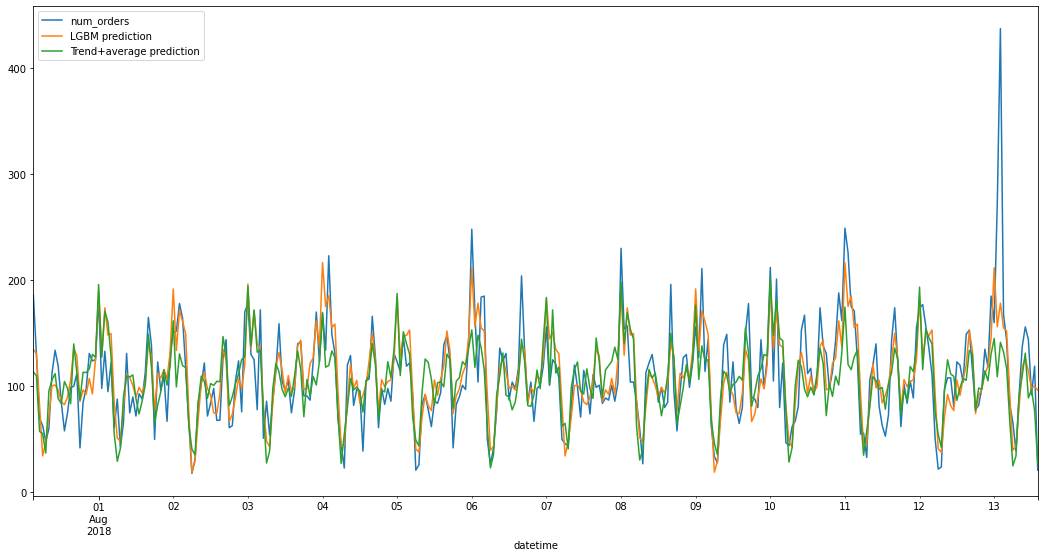

In [45]:
plot_df = pd.DataFrame(target_test)
plot_df['LGBM prediction'] = lgbm_model.predict(features_test)
plot_df['Trend+average prediction'] = test_average['average_fixed']
plot_df.plot(figsize=(18,9))
plt.show()

Интересно, что LightGBM в итоге рисует что-то весьма отличное от средних за недели. Получается, что модель нашла какую-то возможность предсказывать "шумовую" часть декомпозиции по предыдущим значениям.

## Результаты и выводы
* В результате оптимизации модель LightGBM показала результат RMSE = 28.6 на тестовой выборке.
* Ни один из предложенных признаков, описывающих последнюю динамику, не улучшил предсказаний. Оптимальным оказалось обучать модели только на усредняющих по большим интервалам времени признакам.
* Простая модель с линейной экстраполяцией средних значений показывает неплохие результаты
* OHE для дней недели полезно всем моделям
* OHE для номера часа полезно для линейной регрессии и мешает деревьям
* Гипотеза о неактуальности старых данных проверена и отвергнута, учиться оказалось лучше на всей выборке

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48